In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
# cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

/Users/theoares/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


## Initialize data

In [2]:
n_ens = 5
n_ops = 5
ensembles = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
colors = ['r', 'g', 'b', 'c', 'y']
L_cfgs = [24, 24, 32, 32, 32]
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_24I = [1.784, 0.005]
ainv_32I = [2.382, 0.008]

# # PDG values
# mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
# fpi_0 = (0.1302, 1.2e-3)
# David's values for testing-- use PDG values after testing
mpi_0   = [ 0.13957018, 0.00000035 ]
fpi_0   = [ 0.13041, np.sqrt(0.00003**2 + 0.00020**2) ]

In [3]:
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # Can change if I want to bootstrap each file differently
mpi_0_ens, fpi_0_ens = Superboot(n_ens), Superboot(n_ens)
mpi_0_ens.gen_fake_ensemble(mpi_0[0], mpi_0[1])
fpi_0_ens.gen_fake_ensemble(fpi_0[0], fpi_0[1])

# generate lattice ensemble for each size and map between ensemble <--> size
ainv_24I_ens = Superboot(n_ens)
ainv_32I_ens = Superboot(n_ens)
ainv_24I_ens.gen_fake_ensemble(ainv_24I[0], ainv_24I[1])
ainv_32I_ens.gen_fake_ensemble(ainv_32I[0], ainv_32I[1])
ainv_ens = [ainv_24I_ens, ainv_24I_ens, ainv_32I_ens, ainv_32I_ens, ainv_32I_ens]

hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
asq_24I_ens = ainv_24I_ens ** (-2)
asq_32I_ens = ainv_32I_ens ** (-2)
asq_24I_fms = asq_24I_ens.scale(hbarc ** 2)
asq_32I_fms = asq_32I_ens.scale(hbarc ** 2)
asq_ens = [asq_24I_fms, asq_24I_fms, asq_32I_fms, asq_32I_fms, asq_32I_fms]

In [4]:
print('a for 24I lattices: ' + str(hbarc / ainv_24I[0]) + ' fm')
print('a for 32I lattices: ' + str(hbarc / ainv_32I[0]) + ' fm')

a for 24I lattices: 0.11060874439461883 fm
a for 32I lattices: 0.08284047019311502 fm


### Renormalize bare matrix elements in NPR basis

In [5]:
# get RCs for Z_ij / Z_V^2 and Z_A
rc_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/Z_pert_run.h5', \
            '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/Z_pert_run.h5']
fRCs = [h5py.File(path, 'r') for path in rc_paths]
ZijZVsq_24I_NPR = fRCs[0]['MSbar'][()]    # (ens_idx, boot_idx, i, j) in NPR basis
ZijZVsq_32I_NPR = fRCs[1]['MSbar'][()]
[f.close() for f in fRCs]

ZA_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/ZA.h5', \
            '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/ZA.h5']
fZAs = [h5py.File(path, 'r') for path in ZA_paths]
ZA_24I = fZAs[0]['ZA'][()]    # (ens_idx, boot_idx)
ZA_32I = fZAs[1]['ZA'][()]
[f.close() for f in fZAs]

[None, None]

In [6]:
k = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 2, 0], [2, 0, 0, 0, 0], [0, 0, -2, 0, 0], [0, 0, 0, -1, 1]], dtype = np.float64) / 4.0
kinv = np.linalg.inv(k)
# TODO think of statistics here: these bootstraps are on different configs than the bare matrix elements, how to 
# combine the errors? Can we generate fake bootstrap data with the correct statistics and mean?
ZijZVsq_24I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_24I_NPR, kinv)
ZijZVsq_32I_BSM = np.einsum('ij,...jk,kl->...il', k, ZijZVsq_32I_NPR, kinv)
# get mean and std for 32I to generate fake data for ml0p008
Z32I_mu_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
Z32I_std_BSM = np.zeros((n_ops, n_ops), dtype = np.float64)
Z_32Iml0p008 = np.zeros((n_boot, n_ops, n_ops), dtype = np.float64)
for i in range(n_ops):
    for j in range(n_ops):
        tmp = Superboot(2)
        tmp.boots = ZijZVsq_32I_BSM[:, :, i, j]
        Z32I_mu_BSM[i, j] = tmp.compute_mean()
        Z32I_std_BSM[i, j] = tmp.compute_std()
        Z_32Iml0p008[:, i, j] = gen_fake_ensemble([Z32I_mu_BSM[i, j], Z32I_std_BSM[i, j]], n_samples = n_boot)
ZijZVsq_BSM = np.zeros((n_ens, n_boot, n_ops, n_ops), dtype = np.float64)
ZijZVsq_BSM[0] = ZijZVsq_24I_BSM[1]    # 24I/ml0p01
ZijZVsq_BSM[1] = ZijZVsq_24I_BSM[0]    # 24I/ml0p005
ZijZVsq_BSM[2] = Z_32Iml0p008    # 32I/ml0p008
ZijZVsq_BSM[3] = ZijZVsq_32I_BSM[1]    # 32I/ml0p006
ZijZVsq_BSM[4] = ZijZVsq_32I_BSM[0]    # 32I/ml0p004
ZA = np.zeros((n_ens, n_boot), dtype = np.float64)
ZA[0] = ZA_24I[0]
ZA[1] = ZA_24I[1]
ZA[2] = ZA_32I[0]
ZA[3] = ZA_32I[1]
ZA[4] = ZA_32I[2]

In [7]:
# select the renormalization coeffs to use
# Zij_BSM = ZijZVsq_BSM
Zij_BSM = np.einsum('...,...ij->...ij', ZA ** 2, ZijZVsq_BSM)

# Uncomment here if we want to run bare matrix elements
# Zij_BSM = np.zeros((5, 50, 5, 5), dtype = np.float64)
# for a in range(n_ens):
#     for b in range(n_boot):
#         Zij_BSM[a, b] = np.eye(5)

In [27]:
print(ZA[0, 0])
print(ZA[2, 0])

0.7168169284072378
0.7448572952092424


In [25]:
ZijZVsq_BSM[0, 0]

array([[ 1.19112257,  0.        ,  0.        , -0.1408995 ,  0.        ],
       [ 0.        ,  1.04332295,  0.        ,  0.        , -0.05645796],
       [ 0.        ,  0.        ,  1.03730769,  0.        ,  0.        ],
       [-0.12152134,  0.        ,  0.        ,  1.12204817,  0.        ],
       [ 0.        ,  0.02885408,  0.        ,  0.        ,  1.31357653]])

In [23]:
Zij_BSM[0, 0]

array([[ 0.61203035,  0.        ,  0.        , -0.0723979 ,  0.        ],
       [ 0.        ,  0.53608699,  0.        ,  0.        , -0.0290096 ],
       [ 0.        ,  0.        ,  0.53299619,  0.        ,  0.        ],
       [-0.06244089,  0.        ,  0.        ,  0.5765381 ,  0.        ],
       [ 0.        ,  0.01482599,  0.        ,  0.        ,  0.67495044]])

#### Use my data (for actual final analysis)

In [8]:
# Generate fake ensembles. 
mat_elems_bare = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # bare mat elems
mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]    # renorm mat elems
mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elems_raw = f['fits'][()]
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        a4_mat_elems_raw[:, i] *= mult_factor
        a4_mat_elems_ens = Superboot(n_ens)
        a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
        mat_elems_bare[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
    f.close()
    # renormalize matrix elements
    a4_mat_elems_renorm = np.einsum('bij,bj->bi', Zij_BSM[ens_idx], a4_mat_elems_raw)
    for i in range(n_ops):
        a4_mat_elems_r_ens = Superboot(n_ens)
        a4_mat_elems_r_ens.populate_ensemble(a4_mat_elems_renorm[:, i], ens_idx)
        mat_elems_ens[ens_idx][i] = a4_mat_elems_r_ens * (ainv_ens[ens_idx] ** 4)
    # read in two point data
    ampi_ens = Superboot(n_ens)
    afpi_ens = Superboot(n_ens)
    # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
    path2pt = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/twopt_out.h5'
    twopt_data = h5py.File(path2pt, 'r')
    ampi_boot = twopt_data['ampi']
    afpi_boot = twopt_data['afpi']
    ampi_ens.populate_ensemble(ampi_boot, ens_idx)
    afpi_ens.populate_ensemble(afpi_boot, ens_idx)

    mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
    fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
    eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
    eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's data

In [9]:
# # David's data
# ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
# afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
# # enter this data in format [ens_idx, op_idx] with pairs (mu, sigma)
# a4_matelem_david = np.array([
#     [[-0.04648, 0.00025], [-0.07996, 0.00057], [0.002768, 0.000013], [-0.14345, 0.00080], [0.01951, 0.00014]], 
#     [[-0.03903, 0.00026], [-0.06667, 0.00065], [0.0013953, 0.0000095], [-0.12229, 0.00081], [0.01633, 0.00016]], 
#     [[-0.01476, 0.00011], [-0.02323, 0.00024], [0.0006677, 0.0000043], [-0.04591, 0.00036], [0.005778, 0.000061]], 
#     [[-0.013052, 0.000094], [-0.02059, 0.00020], [0.0004511, 0.0000028], [-0.04087, 0.00030], [0.005132, 0.000050]], 
#     [[-0.011753, 0.000091], [-0.01847, 0.00021], [0.0002745, 0.0000022], [-0.03705, 0.00029], [0.004608, 0.000053]]
# ])

# # Generate fake ensembles. 
# mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
# mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     for i in range(n_ops):
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4_mat_elems_ens = Superboot(n_ens)
#         a4_mat_elems_ens.gen_fake_ensemble_axis(a4_matelem_david[ens_idx, i, 0], a4_matelem_david[ens_idx, i, 1], ens_idx)
#         a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
#         mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
#     ampi_ens = Superboot(n_ens)
#     afpi_ens = Superboot(n_ens)
#     # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
#     # This reads in david's values for ampi, afpi and should be used for testing.
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Use David's 2pt function data with my matrix elements

In [10]:
# # Generate fake ensembles. 
# ampi_david = np.array([[0.24160, 0.00045], [0.19131, 0.00051], [0.17277, 0.00056], [0.15077, 0.00045], [0.12652, 0.00039]])
# afpi_david = np.array([[0.09177, 0.00025], [0.08495, 0.00025], [0.06802, 0.00030], [0.06477, 0.00020], [0.06194, 0.00027]])
# mat_elems_ens = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
# mpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# fpi_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_ens = [Superboot(n_ens) for i in range(n_ens)]
# eps_sq_phys_ens = [Superboot(n_ens) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
#     f = h5py.File(path, 'r')
#     a4_mat_elems_raw = f['fits'][()]
#     for i in range(n_ops):
#         # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4_mat_elems_ens = Superboot(n_ens)
#         a4_mat_elems_ens.populate_ensemble(a4_mat_elems_raw[:, i], ens_idx)
#         a4_mat_elems_ens = a4_mat_elems_ens.scale(mult_factor)
#         mat_elems_ens[ens_idx][i] = a4_mat_elems_ens * (ainv_ens[ens_idx] ** 4)
#     f.close()
#     ampi_ens = Superboot(n_ens)
#     afpi_ens = Superboot(n_ens)
#     # this reads in my ampi, afpi from the two point analysis, and should be used in the actual analysis.
#     # This reads in david's values for ampi, afpi and should be used for testing.
#     ampi_ens.gen_fake_ensemble_axis(ampi_david[ens_idx][0], ampi_david[ens_idx][1], ens_idx)
#     afpi_ens.gen_fake_ensemble_axis(afpi_david[ens_idx][0], afpi_david[ens_idx][1], ens_idx)

#     mpi_ens[ens_idx] = ampi_ens * ainv_ens[ens_idx]
#     fpi_ens[ens_idx] = afpi_ens * ainv_ens[ens_idx]
#     eps_sq_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_ens[ens_idx]**2).scale(8 * (np.pi**2))
#     eps_sq_phys_ens[ens_idx] = (mpi_ens[ens_idx]**2) / (fpi_0_ens**2).scale(8 * (np.pi**2))

#### Propagate error and print data

In [11]:
# generate information in tables 2 and 3-- get the mean and STD of bootstrapped ensembles
print('Running statistics with physical units')
mat_elem_bare_mu = [[mat_elems_bare[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)]
mat_elem_bare_sigma = [[mat_elems_bare[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)]

mat_elem_mu = [[mat_elems_ens[i][j].compute_mean() for j in range(n_ops)] for i in range(n_ens)]
mat_elem_sigma = [[mat_elems_ens[i][j].compute_std() for j in range(n_ops)] for i in range(n_ens)]

mpi_mu = [mpi_ens[i].compute_mean() for i in range(n_ens)]
mpi_sigma = [mpi_ens[i].compute_std() for i in range(n_ens)]
fpi_mu = [fpi_ens[i].compute_mean() for i in range(n_ens)]
fpi_sigma = [fpi_ens[i].compute_std() for i in range(n_ens)]
eps_mu = [eps_sq_ens[i].compute_mean() for i in range(n_ens)]
eps_sigma = [eps_sq_ens[i].compute_std() for i in range(n_ens)]
eps_phys_mu = [eps_sq_phys_ens[i].compute_mean() for i in range(n_ens)]
eps_phys_sigma = [eps_sq_phys_ens[i].compute_std() for i in range(n_ens)]
ainv_ens_mu = [ainv_ens[i].compute_mean() for i in range(n_ens)]
ainv_ens_sigma = [ainv_ens[i].compute_std() for i in range(n_ens)]
asq_ens_mu = [asq_ens[i].compute_mean() for i in range(n_ens)]
asq_ens_sigma = [asq_ens[i].compute_std() for i in range(n_ens)]

for ens_idx in range(n_ens):
    print(ensembles[ens_idx])
    print('a^-1 = ' + str(ainv_ens_mu[ens_idx]) + ' \pm ' + str(ainv_ens_sigma[ens_idx]) + ' GeV')
    print('a^2 = ' + str(asq_ens_mu[ens_idx]) + ' \pm ' + str(asq_ens_sigma[ens_idx]) + ' fm^2')
    print('m_pi: ' + str(mpi_mu[ens_idx]) + ' \pm ' + str(mpi_sigma[ens_idx]) + ' GeV')
    print('f_pi: ' + str(fpi_mu[ens_idx]) + ' \pm ' + str(fpi_sigma[ens_idx]) + ' GeV')
    print('epsilon_pi_sq: ' + str(eps_mu[ens_idx]) + ' \pm ' + str(eps_sigma[ens_idx]))
    print('epsilon_pi_phys_sq (to plot at): ' + str(eps_phys_mu[ens_idx]) + ' \pm ' + str(eps_phys_sigma[ens_idx]))
    for op_idx in range(n_ops):
        print(labels[op_idx]+' bare: '+str(mat_elem_bare_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_bare_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
        print(labels[op_idx]+' renorm: '+str(mat_elem_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
    print('\n')

Running statistics with physical units
24I/ml_0p01
a^-1 = 1.78411981993478 \pm 0.004782718774455845 GeV
a^2 = 0.012232703160252099 \pm 6.560909526837971e-05 fm^2
m_pi: 0.43068504944284536 \pm 0.0015199647306380101 GeV
f_pi: 0.16440693467041673 \pm 0.0006890027656072396 GeV
epsilon_pi_sq: 0.08691464952718174 \pm 0.0007237873786428644
epsilon_pi_phys_sq (to plot at): 0.13812619459023168 \pm 0.0007116509702149741
O1 bare: -0.029388761832661838 \pm 0.0003864576901379262 (GeV)^4
O1 renorm: -0.011436712752134091 \pm 0.00014836461667603465 (GeV)^4
O2 bare: -0.10125344202213361 \pm 0.001455203565467493 (GeV)^4
O2 renorm: -0.05506423540737298 \pm 0.0007826910460257549 (GeV)^4
O3 bare: 0.0035042343828550065 \pm 4.355682612377701e-05 (GeV)^4
O3 renorm: 0.0018699562694526328 \pm 2.3004140228212826e-05 (GeV)^4
O1p bare: -0.09081412990659629 \pm 0.0012002947719437227 (GeV)^4
O1p renorm: -0.05059382046055988 \pm 0.0006631777830174083 (GeV)^4
O2p bare: 0.024706950436744864 \pm 0.00035511931985637634 (

<IPython.core.display.Javascript object>


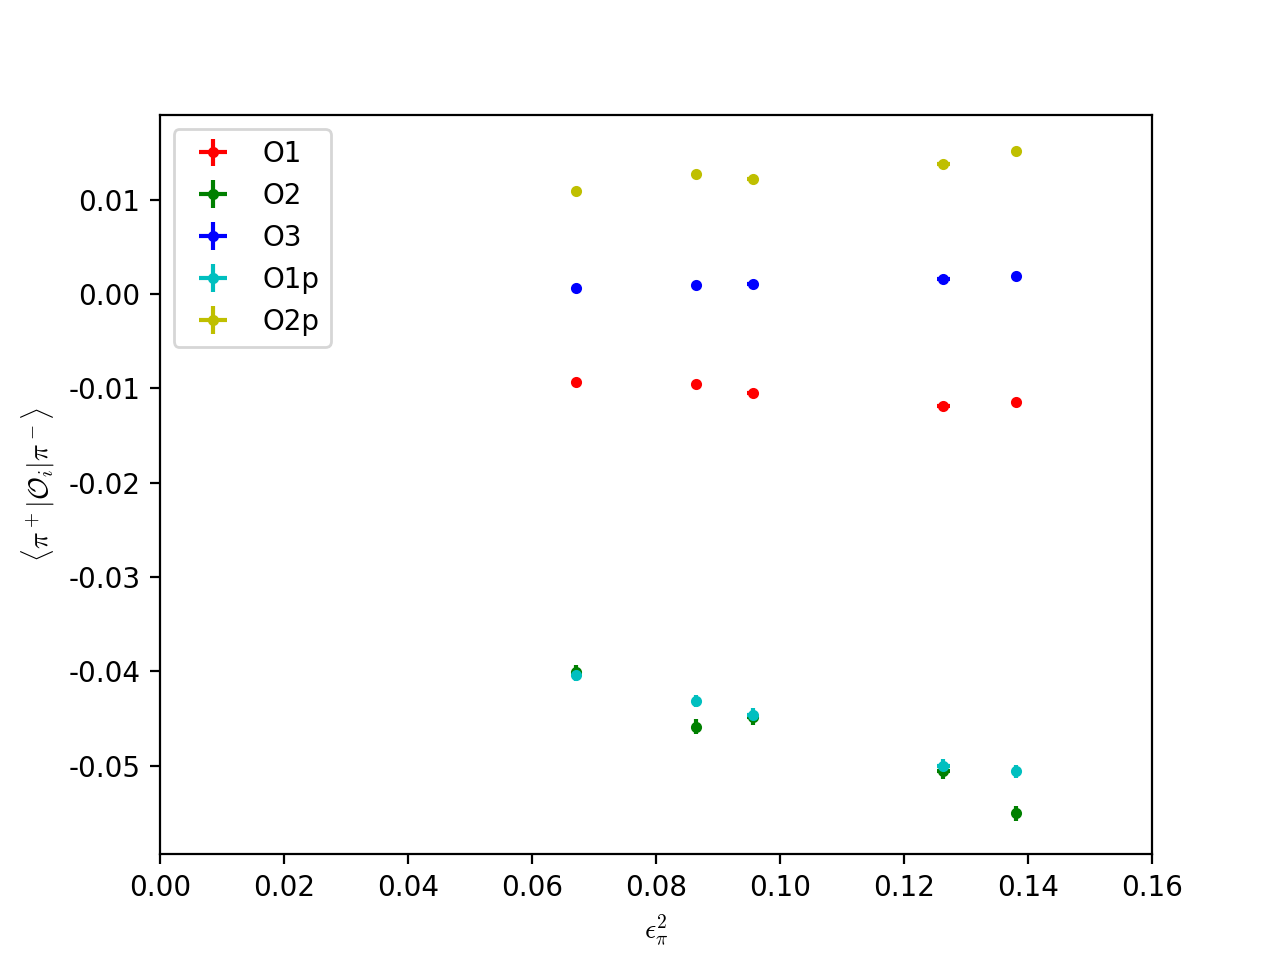

In [12]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
plt.figure()
for i in range(n_ops):
    plt.errorbar(eps_phys_mu, [mat_elem_mu[j][i] for j in range(n_ens)], xerr = eps_phys_sigma, yerr = [mat_elem_sigma[j][i] for j in range(n_ens)], fmt = '.', c = colors[i], label = labels[i])
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('$\\langle \pi^+ | \mathcal{O}_i | \pi^- \\rangle$')
plt.legend()
plt.xlim((0, 0.16))
# plt.ylim((-0.08, 0.02))
plt.show()

## Perform the fit

In [13]:
def f0(m, L, ainv):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, (m / ainv) * L * n)
    return f0
def f1(m, L, ainv):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, (m / ainv) * L * n) / ((m / ainv) * L * n)
    return f1
# for O1, O2, O1p, O2p, fv = -f0 + 2*f1, for O3 fv = f0 + 2*f1
def get_fv_fn(op_idx):
    if op_idx == 2:    # for O3
        return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, L, ainv)
    return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, L, ainv)
# this mirrors David's code, but it should be a bug: inputs L = 32 for the f1 piece regardless of ensemble.
#     if op_idx == 2:    # for O3
#         return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, 32, ainv)
#     return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, 32, ainv)

In [14]:
# Define functional fit forms for the operators (these agree with David's functions)
def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m ** 2) / Lam_sq
    return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
def O2(a2, b2, c2, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
def O3(a3, b3, c3, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
def get_chi2(O_fn):
    def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
        val = 0.0
        for j in range(n_ens):
            val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
        return val
    return chi2
O_list = [O1, O2, O3, O1, O2]
chi2_list = [get_chi2(Oi) for Oi in O_list]

#### Fit to mean

In [15]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
    O_elems = np.array([mat_elem_mu[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    O_elems_sigma = np.array([mat_elem_sigma[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_mu, fpi_mu, asq_ens_mu, \
            fv_list, O_elems, O_elems_sigma), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    guesses1[op_idx, :] = out['x'][:]

0
1
2
3
4


In [16]:
# the difference in fits to mean each time I run them is due to uncertainty in the lattice spacing, since I haven't 
# seeded the random number generator for the fake ensembles
print('Results of fits to mean:')
print('α | β | c')
for i in range(n_ens):
    print(labels[i])
    print(guesses1[i])

Results of fits to mean:
α | β | c
O1
[-10.21277908  -0.68893012   0.08040834]
O2
[ 3.78850614 -2.68198276 -0.29203606]
O3
[3.10987205 0.46356246 0.24102393]
O1p
[-4.2484193  -2.947871   -0.51333459]
O2p
[ 5.69400861  0.72873462 -0.43387908]


#### Fit to full data

In [17]:
alpha = [Superboot(n_ens) for i in range(n_ops)]
beta = [Superboot(n_ens) for i in range(n_ops)]
c = [Superboot(n_ens) for i in range(n_ops)]
# store the matrix elements after subtraction here. phys == actual results subtracted back to the physical point, 
# subtracted == extrapolated results to physical decay constant and lattice spacing at different pion masses. 
# plot eps_sq_subtracted vs mat_elems_subtracted.
mat_elems_phys = [Superboot(n_ens) for j in range(n_ops)]    # extrapolate to the physical pion mass
mat_elems_subtracted = [[Superboot(n_ens) for j in range(n_ops)] for i in range(n_ens)]
chi2_boots = [Superboot(n_ens) for i in range(n_ops)]
chi2_ndof_boots = [Superboot(n_ens) for i in range(n_ops)]
m_range = np.linspace(0.0, 0.5, 101)    # range of m's to plot chiral extrapolation band at
band_data = [[Superboot(n_ens) for j in range(n_ops)] for i in range(len(m_range) - 1)]
for op_idx in range(n_ops):
    print('Operator ' + labels[op_idx])
    fv = get_fv_fn(op_idx)
    guess = guesses1[op_idx]
    O_sigma = np.array([mat_elem_sigma[i][op_idx] for i in range(n_ens)])    # uncertainty doesn't change per boot idx
    for ens_idx in range(n_ens):
        for b_idx in range(n_samples[ens_idx]):
            print('Ensemble ' + str(ens_idx) + ', boot ' + str(b_idx))
            m_boot = np.array([mpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            f_boot = np.array([fpi_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            ainv_boot = np.array([ainv_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            asq_boot = np.array([asq_ens[i].boots[ens_idx, b_idx] for i in range(n_ens)])
            fv_boot = np.array([fv(m_boot[i], L_cfgs[i], ainv_boot[i]) for i in range(n_ens)])
            O_boot = np.array([mat_elems_ens[i][op_idx].boots[ens_idx, b_idx] for i in range(n_ens)])
            out = optimize.minimize(chi2_list[op_idx], guess, args = (m_boot, f_boot, asq_boot, fv_boot, O_boot, \
                                        O_sigma), method = 'Powell', options = {'maxiter' : 10000, 'ftol' : 1.0e-08})
            alphab, betab, cb = out['x']
            print(alphab, betab, cb)
            alpha[op_idx].boots[ens_idx, b_idx] = alphab
            beta[op_idx].boots[ens_idx, b_idx] = betab
            c[op_idx].boots[ens_idx, b_idx] = cb
            chi2_boots[op_idx].boots[ens_idx, b_idx] = out.fun
            chi2_ndof_boots[op_idx].boots[ens_idx, b_idx] = out.fun / (n_ens - 3.0)   # 5 - 3, for 3 fit params
            # subtract off extrapolation @ phys point to get extrapolated matrix element
            mat_elems_phys[op_idx].boots[ens_idx, b_idx] = O_list[op_idx](alphab, betab, cb, mpi_0_ens.boots[ens_idx, b_idx], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            
            # subtract off artifacts and extrapolate everything but the pion mass away-- these are the plotted points
            for i in range(n_ens):
                mat_elems_subtracted[i][op_idx].boots[ens_idx, b_idx] = O_boot[i] \
                    - O_list[op_idx](alphab, betab, cb, m_boot[i], f_boot[i], asq_boot[i], fv_boot[i]) \
                    + O_list[op_idx](alphab, betab, cb, m_boot[i], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)
            for m in range(len(m_range) - 1):    # extrapolate to value m for the pion mass
                band_data[m][op_idx].boots[ens_idx, b_idx] = \
                    O_list[op_idx](alphab, betab, cb, m_range[m + 1], fpi_0_ens.boots[ens_idx, b_idx], 0.0, 0.0)

Operator O1
Ensemble 0, boot 0
-10.671532858029437 -0.6979521708371371 -0.006213806755165877
Ensemble 0, boot 1
-9.95206530726689 -0.6836053504377622 0.1343676245834644
Ensemble 0, boot 2
-10.110920082326386 -0.6864614953113642 0.10534083089325698
Ensemble 0, boot 3
-10.093304911244475 -0.6869854634756694 0.10320036799306903
Ensemble 0, boot 4
-10.329289498800755 -0.691733770643452 0.05208864960231831
Ensemble 0, boot 5
-10.9267122280133 -0.7036603334512008 -0.06070524536011027
Ensemble 0, boot 6
-11.341536999390293 -0.71256570835672 -0.14202006310789078
Ensemble 0, boot 7
-10.106469333741744 -0.6870948609585256 0.09984384094765747
Ensemble 0, boot 8
-10.162536480690127 -0.687884079433512 0.09221750579461994
Ensemble 0, boot 9
-10.594041957106436 -0.6972029008684065 0.0014003719324858213
Ensemble 0, boot 10
-10.362186021792223 -0.6937218666186522 0.03520170651415321
Ensemble 0, boot 11
-10.273596415808226 -0.6899790562977905 0.06626549563047868
Ensemble 0, boot 12
-10.238945386100252 -

-9.259394550860314 -0.6900561941720791 -0.07810727508273962
Ensemble 2, boot 4
-9.774331834505224 -0.6897379461769787 0.0030264865757399745
Ensemble 2, boot 5
-10.276145713905244 -0.6891604549695658 0.0877889695900353
Ensemble 2, boot 6
-10.978014394174394 -0.6874512283154429 0.2149020584083548
Ensemble 2, boot 7
-10.185889442455148 -0.6889975650755505 0.0703336671206385
Ensemble 2, boot 8
-12.279052178380335 -0.6840929818958585 0.46706922033214693
Ensemble 2, boot 9
-8.403742227844774 -0.6915703016911803 -0.23623231571104203
Ensemble 2, boot 10
-11.506875719141581 -0.6856099451953211 0.3177993092891974
Ensemble 2, boot 11
-10.508775583756172 -0.688608475156656 0.1324534549214659
Ensemble 2, boot 12
-10.84736075750328 -0.6880474801371123 0.19234560345641372
Ensemble 2, boot 13
-10.198009201217385 -0.6894990019172993 0.06930051080404165
Ensemble 2, boot 14
-11.707121113839715 -0.6858084531557703 0.3510524407217381
Ensemble 2, boot 15
-9.677143291851175 -0.6896897668847578 -0.01041412211

-10.126314965024338 -0.6806474535635681 0.16568546502803416
Ensemble 4, boot 8
-10.170773626535635 -0.6860706805308878 0.1083411615935137
Ensemble 4, boot 9
-10.223347924468781 -0.6893865906569856 0.07502438712334435
Ensemble 4, boot 10
-10.249049052962063 -0.6952935799381864 0.018376393160431655
Ensemble 4, boot 11
-10.300336748520042 -0.698847670275024 -0.016130276424008064
Ensemble 4, boot 12
-10.192563505863095 -0.6886249994184898 0.08331741219276256
Ensemble 4, boot 13
-10.117787630690097 -0.6760914214153396 0.21317575050574794
Ensemble 4, boot 14
-10.116015726778876 -0.6768944514954426 0.2021996945459566
Ensemble 4, boot 15
-10.170104124485075 -0.6852232502488989 0.11718408290205184
Ensemble 4, boot 16
-10.443475625050082 -0.7119048275469254 -0.13858597070795883
Ensemble 4, boot 17
-10.373427572417233 -0.7089298411341902 -0.11044323447399623
Ensemble 4, boot 18
-10.27084520207262 -0.6907511857257351 0.06201152299938265
Ensemble 4, boot 19
-10.2621305120593 -0.6972894506499572 -0.

4.286103826274339 -2.6908542068799535 -0.37502474425142573
Ensemble 1, boot 12
1.7306030851477683 -2.6476332181701756 0.0495523650580488
Ensemble 1, boot 13
5.349444800788735 -2.706877371619917 -0.5450820128592937
Ensemble 1, boot 14
5.146598737783465 -2.7030013510769337 -0.5091693771051617
Ensemble 1, boot 15
4.038445631986377 -2.6851234749433948 -0.32938798550651643
Ensemble 1, boot 16
3.735554414378312 -2.6800288007561317 -0.2797134098660131
Ensemble 1, boot 17
2.1813603242398147 -2.6552670960077185 -0.026616005794298264
Ensemble 1, boot 18
2.010964046838726 -2.6519113973781034 0.004149034052893394
Ensemble 1, boot 19
4.017851885404191 -2.686765773466387 -0.33681838805245956
Ensemble 1, boot 20
3.9164396807135082 -2.6837692801299458 -0.31389298992426135
Ensemble 1, boot 21
2.808860479691638 -2.665905786159064 -0.1314162779219133
Ensemble 1, boot 22
3.6176983222064836 -2.6786371499785817 -0.26050262098294763
Ensemble 1, boot 23
2.904224332801284 -2.6667516531857407 -0.143506273443775

3.9699188631866615 -2.674573850957975 -0.29399375926752097
Ensemble 3, boot 17
3.5374998575336027 -2.6920123068060557 -0.2887498787052289
Ensemble 3, boot 18
2.769740504049479 -2.7228909237531203 -0.27569011259066334
Ensemble 3, boot 19
3.715805684657785 -2.6844987032907044 -0.28906162094683513
Ensemble 3, boot 20
4.026892071690812 -2.6715616608263897 -0.2905896591976522
Ensemble 3, boot 21
4.423754038072439 -2.6521492598186587 -0.28208392135543614
Ensemble 3, boot 22
2.1398724026204126 -2.7461896468714913 -0.2563979805601488
Ensemble 3, boot 23
4.746553884338301 -2.6432959633414397 -0.3022632794510253
Ensemble 3, boot 24
3.775932859565148 -2.6826724430702913 -0.29314414334883565
Ensemble 3, boot 25
2.545130309039088 -2.7315893308471146 -0.2706603151017223
Ensemble 3, boot 26
2.207653043078234 -2.7430809120744435 -0.2575651840654376
Ensemble 3, boot 27
3.6816944637583853 -2.687083889057443 -0.2918460803033347
Ensemble 3, boot 28
4.173574289728099 -2.6643912966650856 -0.2894776490731625

3.2391001327759543 0.46253133605527896 0.2777382334373829
Ensemble 0, boot 23
2.668494114004183 0.4670834948708828 0.11635564855717101
Ensemble 0, boot 24
3.7100651519326666 0.45883406253639913 0.4110765009602572
Ensemble 0, boot 25
3.7181457017701436 0.4588294377682793 0.4099309978627201
Ensemble 0, boot 26
2.226124604124913 0.4707401433550833 -0.009633474467673823
Ensemble 0, boot 27
3.1338296485993493 0.46337039269638075 0.24762255853271026
Ensemble 0, boot 28
2.1356257814124464 0.47144874039343904 -0.03340681843372066
Ensemble 0, boot 29
3.015864506546698 0.4643964126653599 0.2114697309865501
Ensemble 0, boot 30
4.4656984347626105 0.4529888627313533 0.6237462767240828
Ensemble 0, boot 31
2.5687034786394127 0.4679500476651124 0.08751575724503399
Ensemble 0, boot 32
2.415486513415297 0.46908289936478254 0.048682403479600296
Ensemble 0, boot 33
2.2002376166278452 0.4705855134347428 0.00015863870892878838
Ensemble 0, boot 34
3.662589318527772 0.4594355038393618 0.3868297721455162
Ensem

1.9871493722950222 0.46178909166704213 0.4966774605157674
Ensemble 2, boot 29
4.065410070750145 0.46507272230661667 0.021235628701570797
Ensemble 2, boot 30
2.9532456333214805 0.4632985593273585 0.2744605020337523
Ensemble 2, boot 31
2.836453415215855 0.46313279052896134 0.30251447986414737
Ensemble 2, boot 32
3.6320795039943374 0.46442484280456936 0.11928009319346171
Ensemble 2, boot 33
3.6368543590611564 0.4642554852493471 0.12529396240320367
Ensemble 2, boot 34
1.328781488003111 0.4606678613080271 0.6531951770784751
Ensemble 2, boot 35
3.2236975798016263 0.4637077290295325 0.2186069961082267
Ensemble 2, boot 36
5.588646487879157 0.4680492873106194 -0.345745019490225
Ensemble 2, boot 37
3.697700155654582 0.4643886851071168 0.11306333853730302
Ensemble 2, boot 38
2.159006600341088 0.4621236271755548 0.4575463223851721
Ensemble 2, boot 39
4.447252251299494 0.4655013745078213 -0.05700661544998496
Ensemble 2, boot 40
4.2404446423928865 0.4652957528216146 -0.01705954118980429
Ensemble 2, 

3.245002465053805 0.46072717592161366 0.3440785190535981
Ensemble 4, boot 35
3.258024918124453 0.46063615037417627 0.3453152504666997
Ensemble 4, boot 36
2.305697605383565 0.4806776696492196 -0.35761991190856335
Ensemble 4, boot 37
2.6174591778788923 0.4739687365981853 -0.12812179513674862
Ensemble 4, boot 38
3.432538933071346 0.4569753717430547 0.48244876824465477
Ensemble 4, boot 39
3.139270236051541 0.4630835353994205 0.2572152423904724
Ensemble 4, boot 40
3.030986421770335 0.4652860718664161 0.17895684057405717
Ensemble 4, boot 41
2.4642126633257715 0.47730451697058623 -0.2448278269503845
Ensemble 4, boot 42
3.1698251956305343 0.4622440758871503 0.2886348435617311
Ensemble 4, boot 43
3.5218911372994053 0.4554910207073873 0.5349558111639796
Ensemble 4, boot 44
2.5758733069352204 0.4745663283947169 -0.14847364725015186
Ensemble 4, boot 45
3.172126467664375 0.46229670110025944 0.28687753470414595
Ensemble 4, boot 46
3.025663076289709 0.46529804947343845 0.17835569380699465
Ensemble 4,

-4.6678853540598775 -2.940851403999337 -0.44870909247956275
Ensemble 1, boot 40
-6.033821241869789 -2.9145108378702527 -0.22425306219802235
Ensemble 1, boot 41
-4.581236578386671 -2.9407895456070032 -0.455564641083185
Ensemble 1, boot 42
-4.094591596599685 -2.9496934162933135 -0.5352850414551299
Ensemble 1, boot 43
-4.283330591658351 -2.9471035715353078 -0.5082021454070632
Ensemble 1, boot 44
-3.8152900057313217 -2.9549154196752507 -0.5800128683169857
Ensemble 1, boot 45
-1.4377535346618613 -2.9982055945247286 -0.9549477789712583
Ensemble 1, boot 46
-2.8875518370201565 -2.972575450821204 -0.7283782013184911
Ensemble 1, boot 47
-3.0066098067521847 -2.969750205491027 -0.7082917620048705
Ensemble 1, boot 48
-4.5945185785141724 -2.941069558162206 -0.45694458080206457
Ensemble 1, boot 49
-3.23668690832851 -2.9664945666204696 -0.6751761372165448
Ensemble 2, boot 0
-3.6137148446661955 -2.9537227388850504 -0.6283412160286491
Ensemble 2, boot 1
-6.614321504988435 -2.9227806865052246 -0.07581858

-5.3720021944113805 -3.0021832033318643 -0.4805788215499448
Ensemble 3, boot 44
-4.453852158205746 -2.9592026604138506 -0.5105730678518499
Ensemble 3, boot 45
-4.130836732317608 -2.9416210568269743 -0.5146395708768736
Ensemble 3, boot 46
-5.14215980251728 -2.988630311918963 -0.4890184477014675
Ensemble 3, boot 47
-5.680499832333735 -3.015396530957872 -0.4667717340263132
Ensemble 3, boot 48
-2.974654466567951 -2.880187181427316 -0.5211430373877483
Ensemble 3, boot 49
-4.08200280588817 -2.939380475067092 -0.5144581671438471
Ensemble 4, boot 0
-4.6190643317580795 -3.050616621734617 -0.7274576812222165
Ensemble 4, boot 1
-4.219236033299451 -2.9411180044054093 -0.4972132323426385
Ensemble 4, boot 2
-4.25640726549381 -2.9505808080411056 -0.5186838111844713
Ensemble 4, boot 3
-4.424813698498399 -2.9988549501933983 -0.6220345393650867
Ensemble 4, boot 4
-4.086443024784146 -2.904026229257994 -0.41588618553939544
Ensemble 4, boot 5
-4.258496143068141 -2.955273663985369 -0.5293271585148334
Ensemb

7.270822039441408 0.7095659246057875 -0.29768404186134073
Ensemble 1, boot 0
5.94325569566445 0.7298552228659486 -0.4729533753502689
Ensemble 1, boot 1
6.576264836017613 0.7324195467160303 -0.5707869883252631
Ensemble 1, boot 2
6.330084464035198 0.7315356488717302 -0.5357037658692081
Ensemble 1, boot 3
3.085034391799256 0.7168571269385788 -0.0013730928847662685
Ensemble 1, boot 4
4.538870702587065 0.7232349147500203 -0.23739378335239789
Ensemble 1, boot 5
6.420728454761841 0.732411757528338 -0.5593142664859722
Ensemble 1, boot 6
7.396277891771303 0.7360133644577085 -0.7077415365961763
Ensemble 1, boot 7
6.067785531455391 0.7300804474231589 -0.4897906502581056
Ensemble 1, boot 8
4.452756145643098 0.7229595235558829 -0.2278195354411778
Ensemble 1, boot 9
4.873142543724004 0.7254205681311283 -0.3056323740815813
Ensemble 1, boot 10
5.803722135120087 0.7295164054339462 -0.461305887430309
Ensemble 1, boot 11
6.091818206621927 0.7306585058391148 -0.49921154711604765
Ensemble 1, boot 12
3.6782

6.455612168365959 0.7195178377273175 -0.4276353543604812
Ensemble 3, boot 7
5.759452239513457 0.7282611365364833 -0.4393894976409887
Ensemble 3, boot 8
5.612494665404134 0.7295850359805308 -0.43236177378800217
Ensemble 3, boot 9
4.722797848058943 0.7392790407777049 -0.4220218934017618
Ensemble 3, boot 10
4.720096238380725 0.7394316217754231 -0.420392760423885
Ensemble 3, boot 11
6.572836081405228 0.7183955949722025 -0.4322554613944769
Ensemble 3, boot 12
6.659504868393419 0.7173783881150355 -0.4315150867151424
Ensemble 3, boot 13
5.301266675023562 0.7331990798012333 -0.4310206115562686
Ensemble 3, boot 14
7.631805021343766 0.7060512000939998 -0.425138036619753
Ensemble 3, boot 15
5.582103136798665 0.7297680015088875 -0.4296279806077225
Ensemble 3, boot 16
5.881908692330272 0.7266596068888614 -0.4355768132285566
Ensemble 3, boot 17
5.344051336740126 0.7325209805741681 -0.42985172304567176
Ensemble 3, boot 18
4.643111576449855 0.740190209915058 -0.4188329125074721
Ensemble 3, boot 19
5.6

#### Print mean and std for bootstrapped fit parameters

In [18]:
alpha_mu = [alpha[i].compute_mean() for i in range(n_ops)]
alpha_sigma = [alpha[i].compute_std() for i in range(n_ops)]
beta_mu = [beta[i].compute_mean() for i in range(n_ops)]
beta_sigma = [beta[i].compute_std() for i in range(n_ops)]
c_mu = [c[i].compute_mean() for i in range(n_ops)]
c_sigma = [c[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('Fit parameters for operator ' + labels[op_idx])
    print('alpha = ' + str(alpha_mu[op_idx]) + ' \pm ' + str(alpha_sigma[op_idx]))
    print('beta = ' + str(beta_mu[op_idx]) + ' \pm ' + str(beta_sigma[op_idx]))
    print('c = ' + str(c_mu[op_idx]) + ' \pm ' + str(c_sigma[op_idx]))

Fit parameters for operator O1
alpha = -10.213117861118418 \pm 2.130949629956838
beta = -0.6887868130922642 \pm 0.021993463324690966
c = 0.0837328351217462 \pm 0.3799362713563516
Fit parameters for operator O2
alpha = 3.79523570143962 \pm 2.7668036009486534
beta = -2.6812816026486144 \pm 0.10882515946083011
c = -0.28735357590032773 \pm 0.45785428688202423
Fit parameters for operator O3
alpha = 3.114751159310365 \pm 1.834321228028703
beta = 0.4635642403707558 \pm 0.009439249391002196
c = 0.2416999704903474 \pm 0.42172650785678056
Fit parameters for operator O1p
alpha = -4.2460611871755445 \pm 2.2980862024868136
beta = -2.947195462621722 \pm 0.09926871711933624
c = -0.5099075529268933 \pm 0.3911725321294666
Fit parameters for operator O2p
alpha = 5.702142529437298 \pm 2.8293156809159874
beta = 0.7285411679896376 \pm 0.029827787150348443
c = -0.42923217660637886 \pm 0.46092683899354797


#### Get error on data and print subtracted matrix elements

In [19]:
print('Values of chirally extrapolated operators at physical point.')
O_phys_mu = [mat_elems_phys[i].compute_mean() for i in range(n_ops)]
O_phys_sigma = [mat_elems_phys[i].compute_std() for i in range(n_ops)]
for op_idx in range(n_ops):
    print('<pi|' + labels[op_idx] + '|pi> = ' + str(O_phys_mu[op_idx]) + ' \pm ' + str(O_phys_sigma[op_idx]))

Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.007278261334712349 \pm 0.00021248691376160966
<pi|O2|pi> = -0.02816733414972391 \pm 0.0010401156664077117
<pi|O3|pi> = 9.009306284532651e-05 \pm 1.5114307396859098e-06
<pi|O1p|pi> = -0.03085251569135477 \pm 0.0009547092681200378
<pi|O2p|pi> = 0.007636327630888175 \pm 0.00028466927563208593


#### Plot values of the chiral extrapolation at different values of $m_{\pi}$

<IPython.core.display.Javascript object>


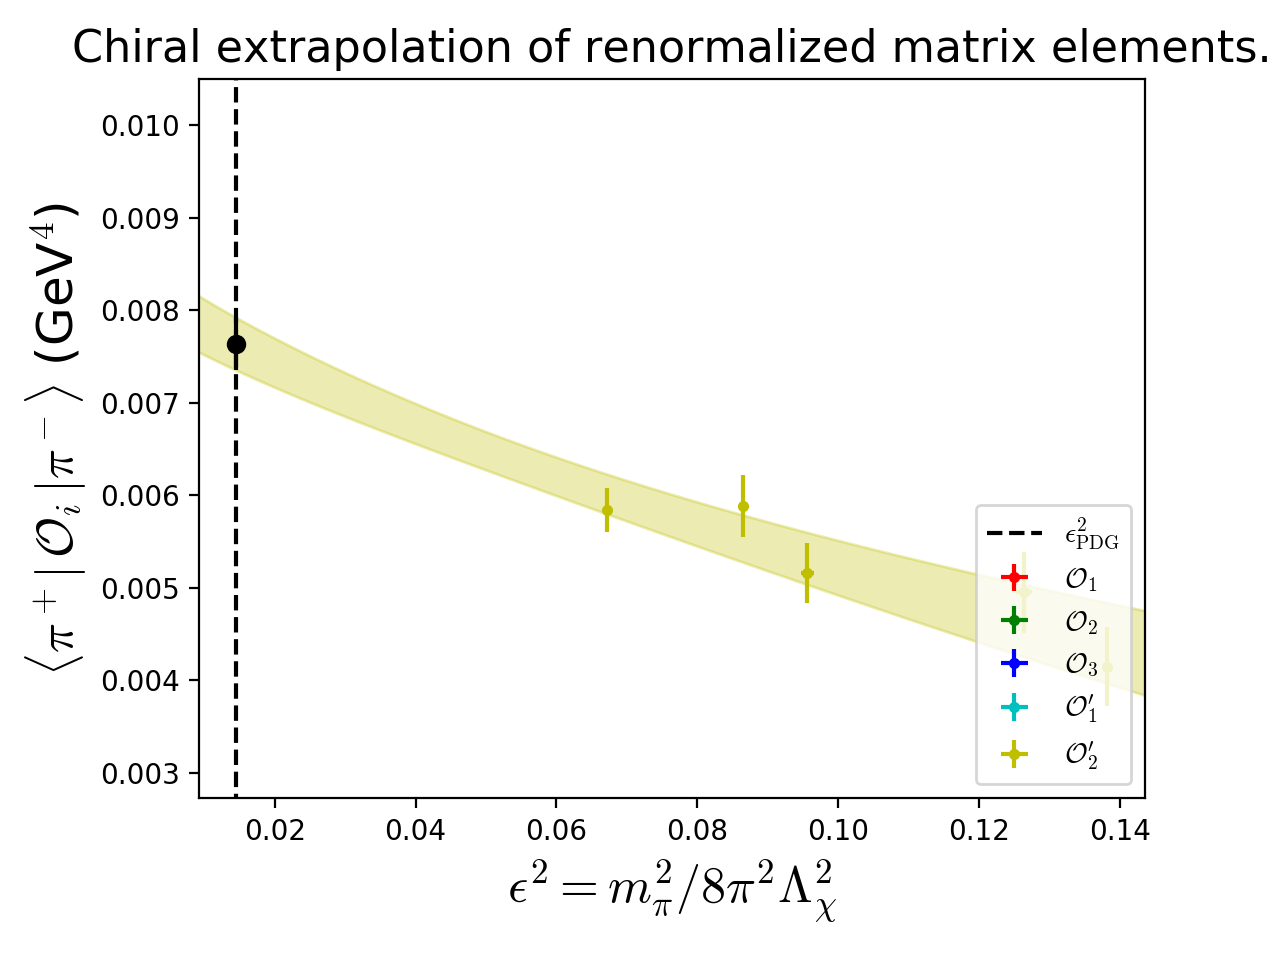

In [20]:
epsilon_sq_range = m_range ** 2 / (8 * (np.pi ** 2) * (fpi_0_ens.avg) ** 2)
eps_sq_0 = mpi_0[0] ** 2 / (8 * (np.pi ** 2) * (fpi_0[0] ** 2))
eps_sq_subtracted = [Superboot(n_ens) for i in range(n_ens)]
for i in range(n_ens):
    for ens_idx in range(n_ens):
        for b_idx in range(n_boot):
            eps_sq_subtracted[i].boots[ens_idx, b_idx] = mpi_ens[i].boots[ens_idx, b_idx] ** 2 / (8 * (np.pi**2) \
                                                            * (fpi_0_ens.boots[ens_idx, b_idx] ** 2))
eps_sq_sub_mu = [eps_sq_subtracted[i].compute_mean() for i in range(n_ens)]    # may want to make .avg instead
eps_sq_sub_sigma = [eps_sq_subtracted[i].compute_std() for i in range(n_ens)]
# get data points
mat_elems_sub_mu = [[mat_elems_subtracted[i][j].compute_mean() for i in range(n_ens)] for j in range(n_ops)]
mat_elems_sub_sigma = [[mat_elems_subtracted[i][j].compute_std() for i in range(n_ens)] for j in range(n_ops)]
# get band
# band_data_mu = [[band_data[i][j].compute_mean() for j in range(n_ops)] for i in range(len(m_range) - 1)]
# band_data_sigma = [[band_data[i][j].compute_std() for j in range(n_ops)] for i in range(len(m_range) - 1)]
band_data_mu = np.array([[band_data[i][j].compute_mean() for i in range(len(m_range) - 1)] for j in range(n_ops)])
band_data_sigma = np.array([[band_data[i][j].compute_std() for i in range(len(m_range) - 1)] for j in range(n_ops)])

labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1 \' $', '$\mathcal{O}_2\' $']
plt.figure()
for j in range(n_ops):
    plt.errorbar(eps_sq_sub_mu, mat_elems_sub_mu[j], xerr = eps_sq_sub_sigma, yerr = mat_elems_sub_sigma[j], \
                 c = colors[j], fmt = '.', label = labels[j])
    plt.fill_between(epsilon_sq_range[1:], band_data_mu[j] + band_data_sigma[j], band_data_mu[j] - band_data_sigma[j], \
                    color = colors[j], alpha = 0.3)
plt.vlines(eps_sq_0, -0.08, 0.02, linestyles = 'dashed', label = '$\epsilon^2_{\mathrm{PDG}}$')
plt.errorbar([eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0, eps_sq_0], O_phys_mu, yerr = O_phys_sigma, c = 'k', fmt = 'o')
plt.legend(loc = 'lower right')
plt.xlim((0.0, 0.16))
plt.ylim((-0.08, 0.02))
plt.title('Chiral extrapolation of renormalized matrix elements.', fontsize = 16)
plt.xlabel('$\epsilon^2 = m_\pi^2 / 8\pi^2\Lambda_\chi^2$', fontsize = 18)
# for some reason matplotlib breaks when we use \rangle in latex?
plt.ylabel('$\\langle \pi^+| \, \mathcal{O}_i \, |\pi^- \\rangle$ (GeV$^4$)', fontsize = 18)
plt.tight_layout()
plt.show()

In [21]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/chiral_extrap/renorm_ZVeq1.pdf')

## Notes

RESULTS FOR FITS TO THE MEAN

I generated fake data based on David's results for mpi and fpi and put them through the function which fits to their means-- it got pretty close to the values that his actual code spits out, when the L value was set to 32 each time. When I corrected the code it was still pretty close to what he had. Here's what David's code spits out:
O1
[-1.3102490330637617, -1.7066608393579843, -0.8422449312953697]
O2
[10.175257387129525, -4.966574781162899, -1.1703248819465772]
O3
[51.5038664286794, 0.6004464229091153, 1.7476029824455277]
O1p
[-1.5315739501273549, -5.489990421744237, -1.0860719237531953]
O2p
[7.343578513224973, 1.2660260632687053, -1.1274407384203236]

Here are the results from my code, using David's numbers to generate fake data, with L = 32 everywhere:
O1
[-1.20250871 -1.699562   -0.85025151]
O2
[10.24026743 -4.94628411 -1.17843114]
O3
[51.17464927  0.60353138  1.60246262]
O1p
[-1.44404244 -5.47414468 -1.10505762]
O2p
[ 7.44079538  1.26197142 -1.11098124]

And here are the results of my code, using David's numbers to generate fake data, with the correct value of L
O1
[-1.47760682 -1.6985531  -0.81686195]
O2
[ 9.98126654 -4.94366356 -1.14693482]
O3
[51.47078419  0.60335902  1.58085964]
O1p
[-1.71935554 -5.47075782 -1.07157295]
O2p
[ 7.17470892  1.26197194 -1.08468667]


Finally, if I use my data (with the correct value of L), I get a very different result. This is likely due to the fact that my fpi fits seem to give pretty different results-- need to check these and see what's going on. In the raw data, notice how the epsilon^2 values seem to be pretty different.
O1
[-7.16650898 -1.72766092 -0.17137882]
O2
[ 3.19326516 -4.9742111  -0.27528603]
O3
[43.60165803  0.63308699  1.39549587]
O1p
[-7.2709804  -5.5523971  -0.41884921]
O2p
[ 0.65288339  1.27018767 -0.2876572 ]

RESULTS FOR FITS TO THE FULL DATA WITH STATISTICS
David's numbers are in the notes he gave me. For the fake data, I generated fake ensembles with his numbers. I've saved plots from the chiral extrapolation in the folder research/0nubb/short_distance/chiral_extrap.

Results from my code using David's numbers to generate fake data, with L = 32 in f1: The plot for this is called 'david_data_buggy_code.pdf'. 
Fit parameters for operator O1
alpha = -1.1952923105750501 \pm 2.4232318685016687
beta = -1.6994125525843942 \pm 0.06894923313114809
c = -0.8478857721620399 \pm 0.42561839796501455
Fit parameters for operator O2
alpha = 10.25607199144804 \pm 3.237465976998419
beta = -4.945760266098866 \pm 0.25418046037910413
c = -1.1746486380349297 \pm 0.5360807050000578
Fit parameters for operator O3
alpha = 51.18682468116901 \pm 2.5406990329994716
beta = 0.6034953545922799 \pm 0.014862089003006899
c = 1.605380169186574 \pm 0.5921588562456657
Fit parameters for operator O1p
alpha = -1.437061479029064 \pm 2.36737668643327
beta = -5.4736652066393034 \pm 0.2175374717957628
c = -1.102885781343092 \pm 0.40934025689340536
Fit parameters for operator O2p
alpha = 7.442395660837931 \pm 0.6403661895226712
beta = 1.2619134184055125 \pm 0.014275051766372084
c = -1.1107447831821937 \pm 0.12393024098384445
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.017695036164755037 \pm 0.00067868856980416
<pi|O2|pi> = -0.05122880377975424 \pm 0.002460141490902251
<pi|O3|pi> = 0.00011926473572161716 \pm 2.338028050502914e-06
<pi|O1p|pi> = -0.056763155854780624 \pm 0.0021450279659343215
<pi|O2p|pi> = 0.013084976490316787 \pm 0.00016967111307890042

Results from my code using David's numbers to generate fake data, with correct value of L in f1:
Fit parameters for operator O1
alpha = -1.4703869550032955 \pm 2.4232374162785835
beta = -1.6984031457401352 \pm 0.06880340920983277
c = -0.8144999249531516 \pm 0.4253689279117576
Fit parameters for operator O2
alpha = 9.997066827141868 \pm 3.2378708235836617
beta = -4.94313880822723 \pm 0.2537642907579481
c = -1.1431567921190475 \pm 0.5359239169173328
Fit parameters for operator O3
alpha = 51.48298021930898 \pm 2.543668509271114
beta = 0.6033305797019024 \pm 0.014884661038272625
c = 1.583327493709689 \pm 0.5932071339905192
Fit parameters for operator O1p
alpha = -1.7123706627798156 \pm 2.3674259990976902
beta = -5.470277244756541 \pm 0.21706558466921363
c = -1.0694054158129125 \pm 0.40910386276330585
Fit parameters for operator O2p
alpha = 7.176317790506278 \pm 0.6397362804138845
beta = 1.2619136971513203 \pm 0.014200927008520178
c = -1.0844519824046788 \pm 0.1236139068843035
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.017693920897671796 \pm 0.0006777561883768293
<pi|O2|pi> = -0.05122744422013253 \pm 0.0024576851975487896
<pi|O3|pi> = 0.00011920018637870915 \pm 2.340104008053997e-06
<pi|O1p|pi> = -0.05675836741349343 \pm 0.0021419892665343818
<pi|O2p|pi> = 0.013090476037653698 \pm 0.00016916232505704334

Results from my code using my data, with correct value of L in f1:
Values of chirally extrapolated operators at physical point.
<pi|O1|pi> = -0.01817977862601922 \pm 0.000537991979223405
<pi|O2|pi> = -0.052255283438707084 \pm 0.0018902251284648097
<pi|O3|pi> = 0.00012479699318107833 \pm 2.5914655655857415e-06
<pi|O1p|pi> = -0.058198972660061216 \pm 0.001722408726239742
<pi|O2p|pi> = 0.01334112508669661 \pm 0.0004690395619702873

Tests with David's data: Run the full analysis by taking David's data points in the document (note that he has saved data for this, but it's jackknifed, so instead I'll just generate fake bootstrapped ensembles) with both the buggy code (the one in David's script with the wrong value of L in f1) and the corrected code. Compare to David's values for the chiral extrapolation. Also note that even with using David's data, since I'm generating a different ensemble from his data it shouldn't match exactly, but it (especially the buggy output) should match his results up to uncertainty.